# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [7]:
import numpy as np
import os
from scipy.misc import imread, imresize ## it has been depricated
import cv2
import datetime
import abc

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
% matplotlib inline
import gc

We set the random seed so that the results don't vary drastically.

In [8]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
#tf.random.set_seed(30)

gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [10]:
project_folder = 'Project_data'

### Utility function for plotting

In [11]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [12]:
# creating a class whose objects will build the different models
class Model(metaclass = abc.ABCMeta):
    
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    
    def initialize_hyperparameters(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
    
    def initialize_image(self, img_height=100, img_width=100):
        self.image_height = img_height
        self.image_width = img_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
        
    def generator(self, source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0, self.total_frames-1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size
            
            for batch in range(num_batches):
                batch_data , batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels
                
            remaining_seq = len(t) % batch_size
            
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels
    
    # function to preprocess one batch of images
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
        
        seq_len = remaining_seq if remaining_seq else batch_size
        
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes))
        
        if (augment):
            batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
            
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
        
        return(batch_data,batch_labels)
    
    # utility function to train the model object
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Ablation experiment

In [14]:
# creating a class that inherits the above model class to help build objects of Conv3D architecture
class ModelConv3D1(Model):
    
    def define_model(self):
        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same', 
                         input_shape=(self.frames_to_sample, self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image(img_height=160,img_width=160)
conv_3d1.initialize_hyperparameters(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

In [18]:
# conv_3d1.train_model(conv_3d1_model)

Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/gradients/max_pooling3d_1/MaxPool3D_grad/MaxPool3DGrad = MaxPool3DGrad[T=DT_FLOAT, TInput=DT_FLOAT, _class=["loc:@max_pooling3d_1/MaxPool3D"], data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_1/cond/Merge, max_pooling3d_1/MaxPool3D, training/Adam/gradients/conv3d_2/convolution_grad/Conv3DBackpropInputV2)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
<br>
<br>
So we get a ResourceExhaustedError error when we use image resolution 160x160 with 30 frames and batch size 40

Lets see how we can trade of to fit our memory constraints

In [23]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image(img_height=100,img_width=100)
conv_3d1.initialize_hyperparameters(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()
conv_3d1.train_model(conv_3d1_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_14 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 50, 50, 32)     128       
__________

In [24]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image(img_height=160,img_width=160)
conv_3d1.initialize_hyperparameters(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()
conv_3d1.train_model(conv_3d1_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_17 (Activation)   (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_18 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 15, 80, 80, 32)    128       
__________

In [25]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image(img_height=160,img_width=160)
conv_3d1.initialize_hyperparameters(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()
conv_3d1.train_model(conv_3d1_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
activation_22 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 8, 80, 80, 32)     128       
__________

In [26]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image(img_height=140,img_width=140)
conv_3d1.initialize_hyperparameters(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()
conv_3d1.train_model(conv_3d1_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 16, 140, 140, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 16, 140, 140, 16)  0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 16, 140, 140, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 8, 70, 70, 16)     0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 8, 70, 70, 32)     4128      
_________________________________________________________________
activation_26 (Activation)   (None, 8, 70, 70, 32)     0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 8, 70, 70, 32)     128       
__________

In [27]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image(img_height=100,img_width=100)
conv_3d1.initialize_hyperparameters(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()
conv_3d1.train_model(conv_3d1_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation_29 (Activation)   (None, 30, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 15, 50, 50, 32)    4128      
_________________________________________________________________
activation_30 (Activation)   (None, 15, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 15, 50, 50, 32)    128       
__________

In [28]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image(img_height=160,img_width=160)
conv_3d1.initialize_hyperparameters(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
conv_3d1.train_model(conv_3d1_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
activation_34 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 8, 80, 80, 32)     128       
__________

We see that image resolution and number of frames have more impact on training than batch size

Also we see that decreasing the batch size leads to overfitting the training data. The max we can take up is [40,16,30,160,160]

# Model 1 - Base Model

## No Data augmentation, batch size 40, 160x160, 20 frames, 15 epochs

In [32]:
class ModelConv3D1(Model):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [33]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image(img_height=160,img_width=160)
conv_3d1.initialize_hyperparameters(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
history1 = conv_3d1.train_model(conv_3d1_model)

Epoch 1/15
17/17 [==============================] - 73s 4s/step - loss: 1.7252 - categorical_accuracy: 0.3630 - val_loss: 4.1740 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2020-12-2715_23_22.572386/model-00001-1.73921-0.35596-4.17399-0.33000.h5
Epoch 2/15
17/17 [==============================] - 45s 3s/step - loss: 1.1997 - categorical_accuracy: 0.5528 - val_loss: 1.4489 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2020-12-2715_23_22.572386/model-00002-1.19387-0.55354-1.44888-0.47000.h5
Epoch 3/15
17/17 [==============================] - 58s 3s/step - loss: 0.8935 - categorical_accuracy: 0.6394 - val_loss: 0.8364 - val_categorical_accuracy: 0.6200

Epoch 00003: saving model to model_init_2020-12-2715_23_22.572386/model-00003-0.89768-0.63801-0.83645-0.62000.h5
Epoch 4/15
17/17 [==============================] - 58s 3s/step - loss: 0.6682 - categorical_accuracy: 0.7454 - val_loss: 0.8291 - val_categorical_accuracy: 0.6600

E

In [34]:
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_37 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_38 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 10, 80, 80, 32)    128       
__________

Clearly the model is overfitting here so we will try augmenting the data

# Model 2

## Augment Data, batch size 20, 160x160, 20 frames, 20 epochs

In [41]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image(img_height=160,img_width=160)
conv_3d2.initialize_hyperparameters(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_45 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_46 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 10, 80, 80, 32)    128       
__________

In [42]:
history2 = conv_3d2.train_model(conv_3d2_model, augment_data=True)

Epoch 1/25
34/34 [==============================] - 139s 4s/step - loss: 1.8532 - categorical_accuracy: 0.4043 - val_loss: 2.3205 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model_init_2020-12-2717_18_53.472211/model-00001-1.86528-0.40196-2.32048-0.49000.h5
Epoch 2/25
34/34 [==============================] - 121s 4s/step - loss: 1.3951 - categorical_accuracy: 0.5350 - val_loss: 1.1350 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2020-12-2717_18_53.472211/model-00002-1.36670-0.53997-1.13498-0.65000.h5
Epoch 3/25
34/34 [==============================] - 132s 4s/step - loss: 1.1502 - categorical_accuracy: 0.5865 - val_loss: 3.7398 - val_categorical_accuracy: 0.3200

Epoch 00003: saving model to model_init_2020-12-2717_18_53.472211/model-00003-1.14718-0.59276-3.73984-0.32000.h5
Epoch 4/25
34/34 [==============================] - 131s 4s/step - loss: 1.0172 - categorical_accuracy: 0.6339 - val_loss: 2.6287 - val_categorical_accuracy: 0.510

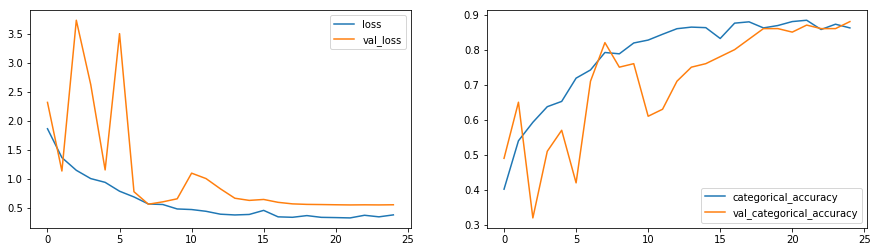

In [43]:
plot(history2)

We get validation accuracy as high as 88% here. However there are fluctuations in the loss so lets reduce the learnin rate to 0.0002

# Model 3

## Augment Data, batch size 30, 120x120, 20 frames, 20 epochs, filter size (2,2,2)

In [9]:
class ModelConv3D3(Model):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image(img_height=120,img_width=120)
conv_3d3.initialize_hyperparameters(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 120, 120, 16)  400       
_________________________________________________________________
activation_1 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 60, 60, 32)    128       
__________

In [11]:
history3 = conv_3d3.train_model(conv_3d3_model, augment_data=True)

Epoch 1/20
34/34 [==============================] - 189s 6s/step - loss: 2.0972 - categorical_accuracy: 0.3543 - val_loss: 1.2003 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2020-12-2719_18_15.205025/model-00001-2.10897-0.35068-1.20028-0.58000.h5
Epoch 2/20
34/34 [==============================] - 104s 3s/step - loss: 1.3831 - categorical_accuracy: 0.5202 - val_loss: 0.9463 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2020-12-2719_18_15.205025/model-00002-1.38854-0.51659-0.94628-0.65000.h5
Epoch 3/20
34/34 [==============================] - 105s 3s/step - loss: 1.3043 - categorical_accuracy: 0.5522 - val_loss: 0.9019 - val_categorical_accuracy: 0.6800

Epoch 00003: saving model to model_init_2020-12-2719_18_15.205025/model-00003-1.25050-0.56184-0.90194-0.68000.h5
Epoch 4/20
34/34 [==============================] - 105s 3s/step - loss: 1.0974 - categorical_accuracy: 0.6107 - val_loss: 0.8478 - val_categorical_accuracy: 0.690

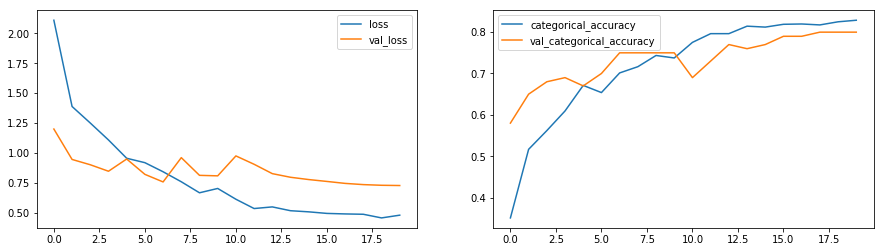

In [12]:
plot(history3)

We are able to reduce the number of parameters by half from the previous model and still maintain an 80% accuracy

# Model 4

## Adding more layers

In [13]:
class ModelConv3D4(Model):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image(img_height=120,img_width=120)
conv_3d4.initialize_hyperparameters(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d4_model=conv_3d4.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 120, 120, 16)  400       
_________________________________________________________________
activation_5 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 20, 120, 120, 16)  64        
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 20, 120, 120, 16)  2064      
_________________________________________________________________
activation_6 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 60, 60, 16)    0         
__________

In [15]:
history4 = conv_3d4.train_model(conv_3d4_model, augment_data=True)

Epoch 1/20
34/34 [==============================] - 124s 4s/step - loss: 2.0175 - categorical_accuracy: 0.3687 - val_loss: 1.5724 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_init_2020-12-2719_58_53.176305/model-00001-1.99596-0.37783-1.57239-0.50000.h5
Epoch 2/20
34/34 [==============================] - 110s 3s/step - loss: 1.5041 - categorical_accuracy: 0.4886 - val_loss: 1.5907 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2020-12-2719_58_53.176305/model-00002-1.51343-0.49246-1.59068-0.52000.h5
Epoch 3/20
34/34 [==============================] - 113s 3s/step - loss: 1.2307 - categorical_accuracy: 0.5806 - val_loss: 1.3112 - val_categorical_accuracy: 0.5900

Epoch 00003: saving model to model_init_2020-12-2719_58_53.176305/model-00003-1.15909-0.59502-1.31115-0.59000.h5
Epoch 4/20
34/34 [==============================] - 113s 3s/step - loss: 1.1542 - categorical_accuracy: 0.5890 - val_loss: 1.3197 - val_categorical_accuracy: 0.610

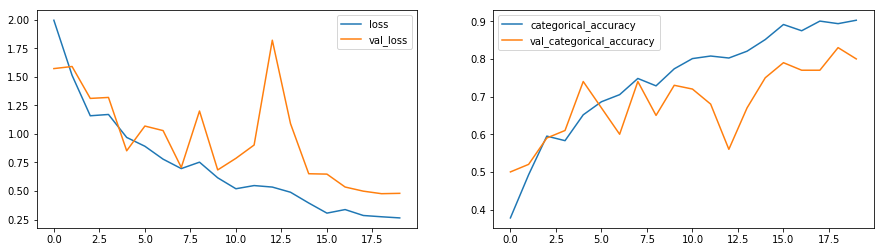

In [16]:
plot(history4)

After adding an additional layer, we see that there is a bit of overfitting

# Model 5

## Adding dropout at convolution layers

In [18]:
class ModelConv3D5(Model):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image(img_height=120,img_width=120)
conv_3d5.initialize_hyperparameters(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_14 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [20]:
history5 = conv_3d5.train_model(conv_3d5_model, augment_data=True)

Epoch 1/22
34/34 [==============================] - 143s 4s/step - loss: 1.7656 - categorical_accuracy: 0.3723 - val_loss: 2.2484 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2020-12-2720_41_58.223556/model-00001-1.77811-0.37330-2.24839-0.37000.h5
Epoch 2/22
34/34 [==============================] - 94s 3s/step - loss: 1.3786 - categorical_accuracy: 0.5011 - val_loss: 1.9193 - val_categorical_accuracy: 0.3700

Epoch 00002: saving model to model_init_2020-12-2720_41_58.223556/model-00002-1.34777-0.50528-1.91929-0.37000.h5
Epoch 3/22
34/34 [==============================] - 93s 3s/step - loss: 1.1977 - categorical_accuracy: 0.5364 - val_loss: 1.0655 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2020-12-2720_41_58.223556/model-00003-1.18151-0.54148-1.06550-0.56000.h5
Epoch 4/22
34/34 [==============================] - 97s 3s/step - loss: 1.0579 - categorical_accuracy: 0.5835 - val_loss: 1.2129 - val_categorical_accuracy: 0.5500



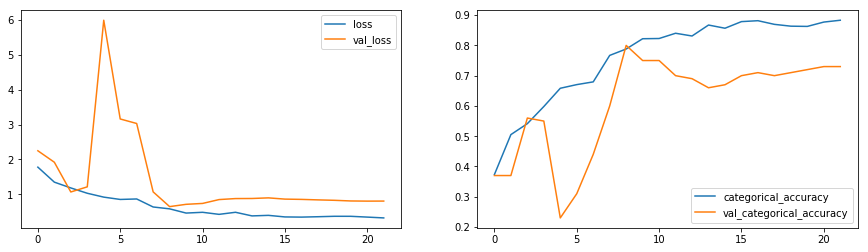

In [21]:
plot(history5)

# Model 6

## Reducing number of parameters

In [22]:
class ModelConv3D6(Model):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image(img_height=100,img_width=100)
conv_3d6.initialize_hyperparameters(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_22 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 8, 50, 50, 32)     128       
__________

In [24]:
history6 = conv_3d6.train_model(conv_3d6_model, augment_data=True)

Epoch 1/30
34/34 [==============================] - 84s 2s/step - loss: 1.9465 - categorical_accuracy: 0.3138 - val_loss: 1.3803 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2020-12-2721_18_26.683670/model-00001-1.92361-0.31750-1.38026-0.42000.h5
Epoch 2/30
34/34 [==============================] - 74s 2s/step - loss: 1.2963 - categorical_accuracy: 0.4842 - val_loss: 1.1657 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_2020-12-2721_18_26.683670/model-00002-1.29887-0.48793-1.16568-0.54000.h5
Epoch 3/30
34/34 [==============================] - 79s 2s/step - loss: 1.1107 - categorical_accuracy: 0.5857 - val_loss: 1.1171 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2020-12-2721_18_26.683670/model-00003-1.08684-0.59201-1.11707-0.57000.h5
Epoch 4/30
34/34 [==============================] - 81s 2s/step - loss: 0.9062 - categorical_accuracy: 0.6442 - val_loss: 0.9528 - val_categorical_accuracy: 0.6100

E

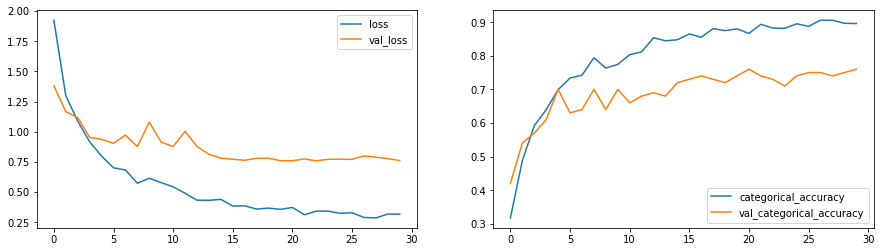

In [25]:
plot(history6)

The model has only 696,645 parameters making its memory footprint relatively low

# Model 7

## CNN-LSTM model, AugmentedData, 120x120, 128 lstm cells, 20 batch size

In [26]:
class RNNCNN1(Model):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image(img_height=120,img_width=120)
rnn_cnn1.initialize_hyperparameters(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [28]:
history7 = rnn_cnn1.train_model(rnn_cnn1_model, augment_data=True)

Epoch 1/20
34/34 [==============================] - 127s 4s/step - loss: 1.4257 - categorical_accuracy: 0.3782 - val_loss: 1.5610 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_2020-12-2721_58_15.431960/model-00001-1.41575-0.37104-1.56101-0.32000.h5
Epoch 2/20
34/34 [==============================] - 88s 3s/step - loss: 1.2072 - categorical_accuracy: 0.5070 - val_loss: 1.1191 - val_categorical_accuracy: 0.5100

Epoch 00002: saving model to model_init_2020-12-2721_58_15.431960/model-00002-1.19860-0.51131-1.11905-0.51000.h5
Epoch 3/20
34/34 [==============================] - 96s 3s/step - loss: 1.0791 - categorical_accuracy: 0.5589 - val_loss: 2.2248 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2020-12-2721_58_15.431960/model-00003-1.08378-0.55204-2.22480-0.23000.h5
Epoch 4/20
34/34 [==============================] - 97s 3s/step - loss: 0.9730 - categorical_accuracy: 0.6045 - val_loss: 2.4381 - val_categorical_accuracy: 0.2300



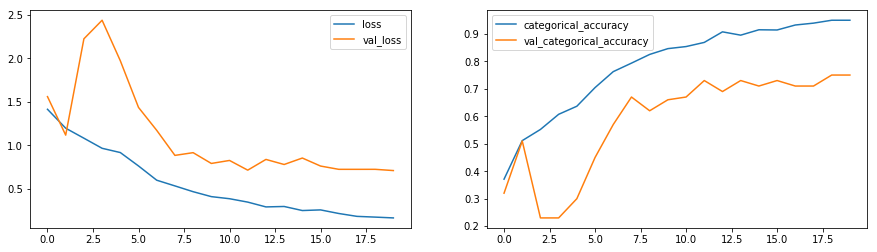

In [29]:
plot(history7)

LSTM is clearly overfitting... lets try with GRU

# Model 8 

## CNN LSTM with GRU 120x120, 128 lstm cells, 20 batch size

In [13]:
class RNNCNN2(Model):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image(img_height=120,img_width=120)
rnn_cnn2.initialize_hyperparameters(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [16]:
history8 = rnn_cnn2.train_model(rnn_cnn2_model, augment_data=True)

Epoch 1/20
34/34 [==============================] - 183s 5s/step - loss: 1.4794 - categorical_accuracy: 0.3837 - val_loss: 1.2201 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2020-12-2809_18_02.511047/model-00001-1.46729-0.38914-1.22010-0.51000.h5
Epoch 2/20
34/34 [==============================] - 96s 3s/step - loss: 1.1433 - categorical_accuracy: 0.5471 - val_loss: 1.0055 - val_categorical_accuracy: 0.6400

Epoch 00002: saving model to model_init_2020-12-2809_18_02.511047/model-00002-1.12897-0.54827-1.00545-0.64000.h5
Epoch 3/20
34/34 [==============================] - 96s 3s/step - loss: 0.8622 - categorical_accuracy: 0.6659 - val_loss: 0.9427 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2020-12-2809_18_02.511047/model-00003-0.86204-0.66591-0.94268-0.66000.h5
Epoch 4/20
34/34 [==============================] - 98s 3s/step - loss: 0.7143 - categorical_accuracy: 0.7248 - val_loss: 0.7865 - val_categorical_accuracy: 0.7400



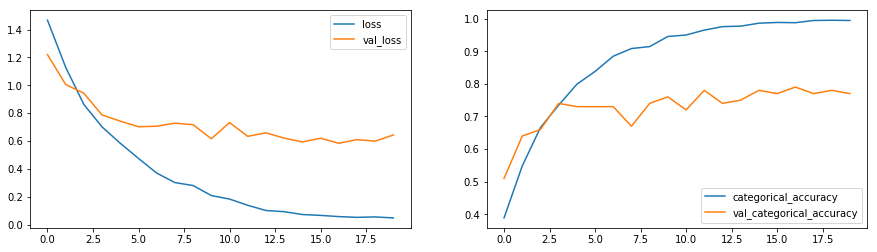

In [17]:
plot(history8)

# Model 9

## CNN LSTM with GRU 140x140, 128 lstm cells, 20 batch size, frames 20

In [24]:
rnn_cnn3=RNNCNN2()
rnn_cnn3.initialize_path(project_folder)
rnn_cnn3.initialize_image(img_height=140,img_width=140)
rnn_cnn3.initialize_hyperparameters(frames_to_sample=16,batch_size=20,num_epochs=20)
rnn_cnn3_model=rnn_cnn3.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_53 (TimeDis (None, 16, 140, 140, 16)  448       
_________________________________________________________________
time_distributed_54 (TimeDis (None, 16, 140, 140, 16)  64        
_________________________________________________________________
time_distributed_55 (TimeDis (None, 16, 70, 70, 16)    0         
_________________________________________________________________
time_distributed_56 (TimeDis (None, 16, 70, 70, 32)    4640      
_________________________________________________________________
time_distributed_57 (TimeDis (None, 16, 70, 70, 32)    128       
_________________________________________________________________
time_distributed_58 (TimeDis (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_59 (TimeDis (None, 16, 35, 35, 64)    18496     
__________

In [25]:
history9 = rnn_cnn3.train_model(rnn_cnn3_model, augment_data=True)

Epoch 1/20
34/34 [==============================] - 131s 4s/step - loss: 1.4620 - categorical_accuracy: 0.3753 - val_loss: 1.2334 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2020-12-2810_07_06.669326/model-00001-1.47175-0.36802-1.23341-0.47000.h5
Epoch 2/20
34/34 [==============================] - 93s 3s/step - loss: 1.1160 - categorical_accuracy: 0.5394 - val_loss: 1.0227 - val_categorical_accuracy: 0.5600

Epoch 00002: saving model to model_init_2020-12-2810_07_06.669326/model-00002-1.10646-0.54449-1.02275-0.56000.h5
Epoch 3/20
34/34 [==============================] - 98s 3s/step - loss: 0.9582 - categorical_accuracy: 0.6218 - val_loss: 0.9965 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2020-12-2810_07_06.669326/model-00003-0.95812-0.62896-0.99652-0.57000.h5
Epoch 4/20
34/34 [==============================] - 97s 3s/step - loss: 0.7830 - categorical_accuracy: 0.7005 - val_loss: 0.9083 - val_categorical_accuracy: 0.6400



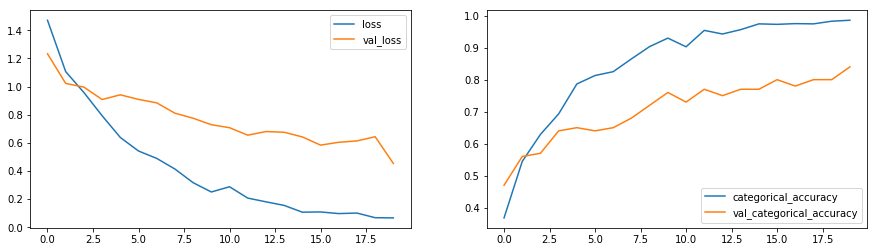

In [26]:
plot(history9)

# Model 10

## Transfer Learning

In [27]:
from keras.applications import mobilenet

In [28]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

17227776/17225924 [==============================] - 2s 0us/step


In [29]:
class RNNCNN_TL(Model):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image(img_height=120,img_width=120)
rnn_cnn_tl.initialize_hyperparameters(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_66 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_67 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_68 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_69 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
__________

In [31]:
history10 = rnn_cnn_tl.train_model(rnn_cnn_tl_model, augment_data=True)

Epoch 1/20
133/133 [==============================] - 92s 695ms/step - loss: 1.4713 - categorical_accuracy: 0.3461 - val_loss: 1.3021 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2020-12-2810_40_02.913716/model-00001-1.47117-0.34615-1.30210-0.47000.h5
Epoch 2/20
133/133 [==============================] - 78s 588ms/step - loss: 1.1503 - categorical_accuracy: 0.5093 - val_loss: 1.2522 - val_categorical_accuracy: 0.4800

Epoch 00002: saving model to model_init_2020-12-2810_40_02.913716/model-00002-1.15179-0.50830-1.25216-0.48000.h5
Epoch 3/20
133/133 [==============================] - 85s 638ms/step - loss: 1.0110 - categorical_accuracy: 0.5965 - val_loss: 1.0953 - val_categorical_accuracy: 0.5100

Epoch 00003: saving model to model_init_2020-12-2810_40_02.913716/model-00003-1.01171-0.59578-1.09531-0.51000.h5
Epoch 4/20
133/133 [==============================] - 84s 631ms/step - loss: 0.8678 - categorical_accuracy: 0.6632 - val_loss: 1.4706 - val_categorical

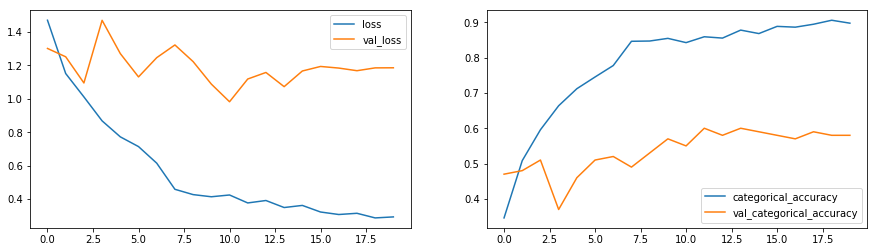

In [32]:
plot(history10)

# Model 11

## Transfer Learning with GRU and training all weights

In [33]:
class RNNCNN_TL2(Model):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [34]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image(img_height=120,img_width=120)
rnn_cnn_tl2.initialize_hyperparameters(frames_to_sample=16,batch_size=10,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_70 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_71 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_72 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_73 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
__________

In [35]:
history11 = rnn_cnn_tl2.train_model(rnn_cnn_tl2_model, augment_data=True)

Epoch 1/20
67/67 [==============================] - 97s 1s/step - loss: 1.0439 - categorical_accuracy: 0.5864 - val_loss: 0.6808 - val_categorical_accuracy: 0.7100

Epoch 00001: saving model to model_init_2020-12-2811_08_13.412571/model-00001-1.04218-0.58899-0.68082-0.71000.h5
Epoch 2/20
67/67 [==============================] - 85s 1s/step - loss: 0.4640 - categorical_accuracy: 0.8269 - val_loss: 0.3942 - val_categorical_accuracy: 0.8500

Epoch 00002: saving model to model_init_2020-12-2811_08_13.412571/model-00002-0.45775-0.83032-0.39418-0.85000.h5
Epoch 3/20
67/67 [==============================] - 93s 1s/step - loss: 0.3630 - categorical_accuracy: 0.8776 - val_loss: 0.3620 - val_categorical_accuracy: 0.8400

Epoch 00003: saving model to model_init_2020-12-2811_08_13.412571/model-00003-0.36659-0.87632-0.36199-0.84000.h5
Epoch 4/20
67/67 [==============================] - 93s 1s/step - loss: 0.2475 - categorical_accuracy: 0.9113 - val_loss: 0.5155 - val_categorical_accuracy: 0.8300

E

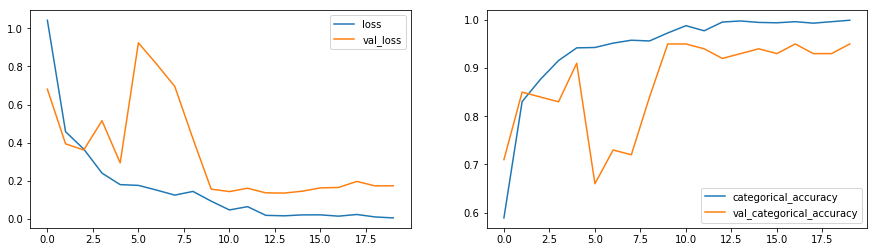

In [36]:
plot(history11)

We are getting a validation accuracy of 95% when we train the weights of mobilenet and add a GRU layer for recurrence ahead of the mobilenet architecture... This is the best performance we have got for any model accuracy wise

__model_init_2020-12-2719_18_15.205025/model-00020-0.48080-0.82881-0.72844-0.80000.h5__ Conv3d model with reduced parameters and a validation accuracy of 80% is something we can go for if we are more leaned towards a real time model and can sacrifice some amount of accuracy.

__model_init_2020-12-2811_08_13.412571/model-00020-0.00576-0.99925-0.17432-0.95000.h5__ mobilenet-GRU model with an accuracy of 95% is our go to model but we will have a tradeoff on the model throughput